## Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

### Preprocessing and getting data

In [18]:
df = pd.read_csv('./dataset/Clustering_dataset(in).csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39.0
1,2,Male,21.0,NaN,81.0
2,3,Female,20.0,16.0,6.0
3,4,Female,23.0,16.0,77.0
4,5,Female,31.0,17.0,40.0


In [19]:
df['Genre'] = df['Genre'].fillna(df['Genre'].mode()[0])

In [20]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Annual Income (k$)'] = df['Annual Income (k$)'].ffill()
df['Spending Score (1-100)'] = df['Spending Score (1-100)'].fillna(df['Spending Score (1-100)'].median())

In [21]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39.0
1,2,Male,21.0,15.0,81.0
2,3,Female,20.0,16.0,6.0
3,4,Female,23.0,16.0,77.0
4,5,Female,31.0,17.0,40.0


In [22]:
#### updating the genre to 0 and 
df['Gender'] = df['Genre'].map({'Male':1,'Female':0})
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Gender
0,1,Male,19.0,15.0,39.0,1
1,2,Male,21.0,15.0,81.0,1
2,3,Female,20.0,16.0,6.0,0
3,4,Female,23.0,16.0,77.0,0
4,5,Female,31.0,17.0,40.0,0


In [23]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Gender
0,1,Male,19.0,15.0,39.0,1
1,2,Male,21.0,15.0,81.0,1
2,3,Female,20.0,16.0,6.0,0
3,4,Female,23.0,16.0,77.0,0
4,5,Female,31.0,17.0,40.0,0


In [24]:
for column in df.columns:
    print(f"column : {column} and missing values : {df[column].isnull().sum()}")
    print(f"min val - {df[column].min()} and max val - {df[column].max()}")

column : CustomerID and missing values : 0
min val - 1 and max val - 200
column : Genre and missing values : 0
min val - Female and max val - Male
column : Age and missing values : 0
min val - 18.0 and max val - 70.0
column : Annual Income (k$) and missing values : 0
min val - 15.0 and max val - 137.0
column : Spending Score (1-100) and missing values : 0
min val - 1.0 and max val - 99.0
column : Gender and missing values : 0
min val - 0 and max val - 1


In [25]:
###final preprocessing step of normalization of each feature
columns = df.columns
# print(columns)
for column in columns:
    if column!='CustomerID' and column!='Genre' and column!='Gender':
        print(f"column : {column} and mean : {df[column].mean()} and std : {df[column].std()}")
        df[column] = (df[column] -df[column].mean())/df[column].std()
df.head()

column : Age and mean : 38.65 and std : 13.814183229255983
column : Annual Income (k$) and mean : 60.55 and std : 26.265316182579152
column : Spending Score (1-100) and mean : 50.34 and std : 25.778616825329006


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100),Gender
0,1,Male,-1.422451,-1.734226,-0.439899,1
1,2,Male,-1.277672,-1.734226,1.189358,1
2,3,Female,-1.350062,-1.696153,-1.720030,0
3,4,Female,-1.132894,-1.696153,1.034190,0
4,5,Female,-0.553779,-1.658080,-0.401108,0


From the data we can observe that there are missing value in each column except customer id.
Now one thing which can be noted in the data is that the annual income is already in increasing order rest all the data for other columns do not have any order.

So for all columns except annual income we can fill the missing values with median or mode in case of categorical data (here gender which is written as *Genre* here :P). 

Not using mean as outliers can affect the mean.

Finally we have done normalization of the data except for customer id, genre and gender.
Not doing for customer id and genre as they are categorical data so will not be used in distance calculation so not of any sense.
Gender is not done as gender is either 0 or 1 so if the gender is different then distance will be 1 else 0 so no need of normalization.

## 2.1 Implementing K-means

In [26]:
class K_Means_Clustering:
    def __init__(self,df : pd.DataFrame, k : int):
        self.df = df
        self.k = k
        self.centroids = None
        self.clusters = None
    
    def fit(self):
        curr_df = self.df.copy()
        curr_df = curr_df.drop(columns=['CustomerID','Genre'])
        print(f"curr_df columns : {curr_df.columns}")
        self.centroids =  curr_df.sample(n=self.k,random_state=42).to_numpy()

        while True:
            self.clusters = {i : [] for i in range(self.k)}
            for point in curr_df.to_numpy():
                distances = np.linalg.norm(point - self.centroids, axis=1)
                ## we have some rows of centroids 
                ### now we calculate the norm of each point with each row thats why 
                ### we specify axis = 1
                cluster = np.argmin(distances)
                self.clusters[cluster].append(point)
            new_centroids = np.array([np.mean(self.clusters[i], axis=0) for i in range(self.k)])
            if np.allclose(new_centroids, self.centroids):
                break
            self.centroids = new_centroids

    def predict(self):
        final_dict = {}
        points = self.df['CustomerID'].to_numpy()
        curr_df = self.df.copy()
        curr_df = curr_df.drop(columns=['CustomerID','Genre'])
        for idx, point in enumerate(curr_df.to_numpy()):
            distances = np.linalg.norm(point - self.centroids, axis=1)
            cluster = np.argmin(distances)
            final_dict[points[idx]] = cluster
        return final_dict
    
    def get_cost(self):
        cost = 0
        for i in range(self.k):
            for point in self.clusters[i]:
                cost += np.linalg.norm(point - self.centroids[i])**2
        return cost

In [27]:
k_means_cluster_obj = K_Means_Clustering(df, 5)

In [28]:
k_means_cluster_obj.fit()

curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')


In [29]:
final_dict = k_means_cluster_obj.predict()
print("First 10 CustomerID to Cluster Mappings:")
count = 0
for customer_id, cluster_label in final_dict.items():
    if count >= 10:
        break
    print(f"CustomerID: {customer_id}, Cluster: {cluster_label}")
    count += 1


First 10 CustomerID to Cluster Mappings:
CustomerID: 1, Cluster: 1
CustomerID: 2, Cluster: 1
CustomerID: 3, Cluster: 2
CustomerID: 4, Cluster: 1
CustomerID: 5, Cluster: 1
CustomerID: 6, Cluster: 1
CustomerID: 7, Cluster: 2
CustomerID: 8, Cluster: 1
CustomerID: 9, Cluster: 2
CustomerID: 10, Cluster: 1


In [30]:
final_cost = k_means_cluster_obj.get_cost()
print(f"Final Cost: {final_cost}")

Final Cost: 220.3742385466814


## 2.2 Optimal number of clusters

### Elbow method    

curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annu

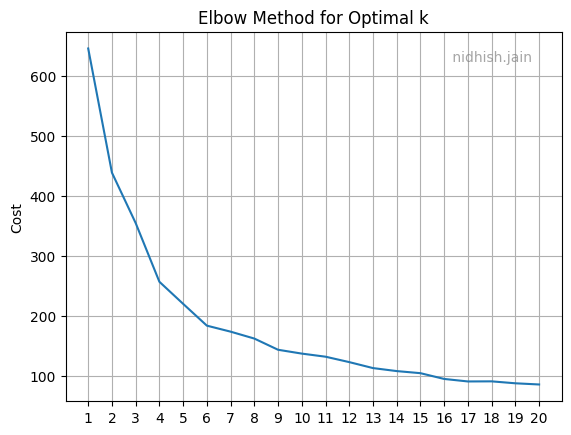

In [31]:
error = {}
for k in range(1,21):
    k_mean_obj = K_Means_Clustering(df, k)
    k_mean_obj.fit()
    error[k] = k_mean_obj.get_cost()

for k in range(1,21):
    print(f"k : {k} and cost : {error[k]} decrement : {error[k-1]-error[k] if k>1 else 0}")

plt.plot(list(error.keys()), list(error.values()))

# Set the x-axis ticks to be the integer values of k
plt.xticks(list(error.keys()))
plt.ylabel("Cost")
plt.title("Elbow Method for Optimal k")
plt . text (
0.95 , 0.95 , " nidhish.jain " ,
ha = 'right' , va = 'top' ,
transform = plt . gca () . transAxes ,
fontsize =10 , color = 'gray' , alpha =0.7
)
plt.grid()
plt.show()

expected trend -> as k increases the wcss cost should decrease as the points will be closer to the centroid.

This has been observed here that the cost does not increase with increase in k 

#### best k?

The best k value from this graph comes near to 6 as after that the decrease in cost is not that significant.

As before it the cost decreases significantly but after it the cost does not decrease that significantly.

From 5-> 6 decrement is of 36 and from 6->7 decrement is of 10.

### Silhouette method

curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender'], dtype='object')
curr_df columns : Index(['Age', 'Annu

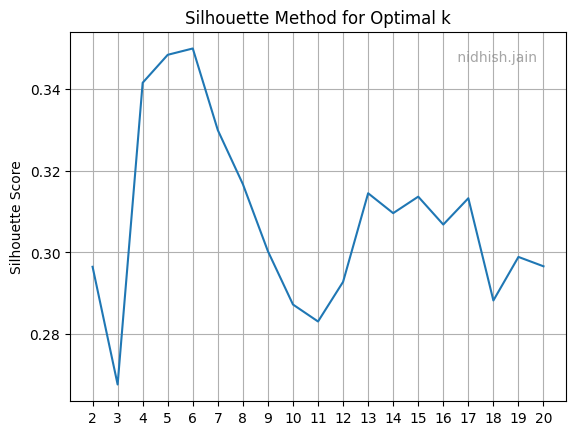

In [32]:
silhouette_scores = {}
for k in range(2,21):
    k_mean_obj = K_Means_Clustering(df, k)
    k_mean_obj.fit()
    predictions = k_mean_obj.predict()
    ordered_pred = [predictions[customer_id] for customer_id in df['CustomerID'].to_numpy()]
    silhouette_avg = silhouette_score(df.drop(columns=['CustomerID','Genre']), ordered_pred)
    silhouette_scores[k] = silhouette_avg
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
plt.xticks(list(silhouette_scores.keys()))
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt . text (
0.95 , 0.95 , " nidhish.jain " ,
ha = 'right' , va = 'top' ,
transform = plt . gca () . transAxes ,
fontsize =10 , color = 'gray' , alpha =0.7
)
plt.grid()
plt.show()

The best silhouette score is for k=6